Om Sai Ram

In [1]:
from qiskit import QuantumCircuit, transpile
from qiskit_aer import Aer
from qiskit.quantum_info import Statevector, Operator, state_fidelity, partial_trace
from qiskit.circuit.library import RXXGate
from matplotlib import pyplot as plt
import numpy as np

# To verify the Unitary $U_{s}$

![fig_2.png]
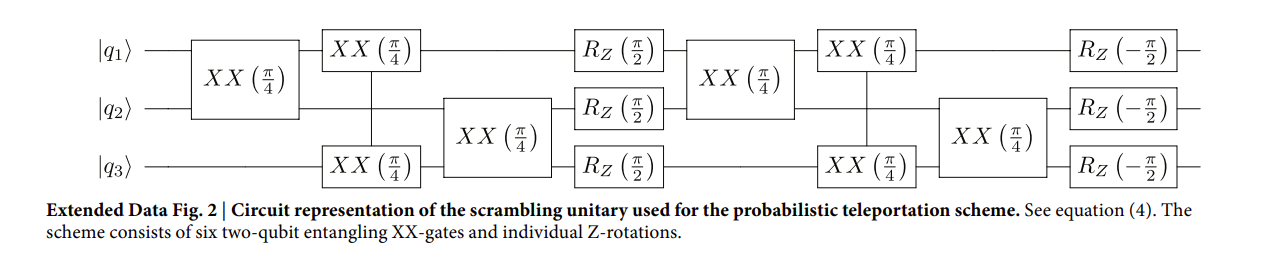

In [2]:
# Scrambling Unitary without any error 

def scrambling_unitary(alpha : float):

    # The value should be pi/4 but in new RXX gate the value of theta is taken as theta/2 so one have to give pi/2 to get pi/4
    rxx_value = np.pi/2 

    # Scrambling parameter is alpha which takes any continuous value between 0 and 1
    # alpha = 0 -> no scrambling
    # alpha = 1 -> scrambling  
    theta = (alpha)*(np.pi/2)  

    rotation_unitary = QuantumCircuit(3)

    rotation_unitary.rxx(rxx_value,0,1)
    rotation_unitary.rxx(rxx_value,0,2)
    rotation_unitary.rxx(rxx_value,1,2)

    rotation_unitary.rz(theta,0)
    rotation_unitary.rz(theta,1)
    rotation_unitary.rz(theta,2)

    rotation_unitary.rxx(rxx_value,0,1)
    rotation_unitary.rxx(rxx_value,0,2)
    rotation_unitary.rxx(rxx_value,1,2)

    rotation_unitary.rz(-theta,0)
    rotation_unitary.rz(-theta,1)
    rotation_unitary.rz(-theta,2)

    #display(rotation_unitary.draw())

    # To ignore the overall factor 1j from the circuit
    unitary_operator = Operator(rotation_unitary)*(-1j) 
    return unitary_operator


# Fully scrambling unitary 
unitary_operator = scrambling_unitary(1)
unitary_operator.draw('latex', prefix="U_{s}= ")

<IPython.core.display.Latex object>

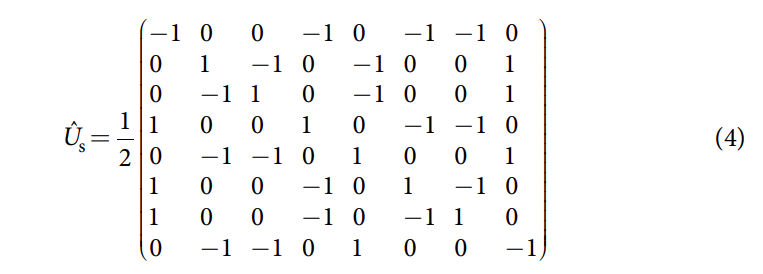

# Quantum Scrambling Parameterization

Trying to reproduce the graphs in this image. 

![Graph 2.png](<attachment:Graph 2.png>)

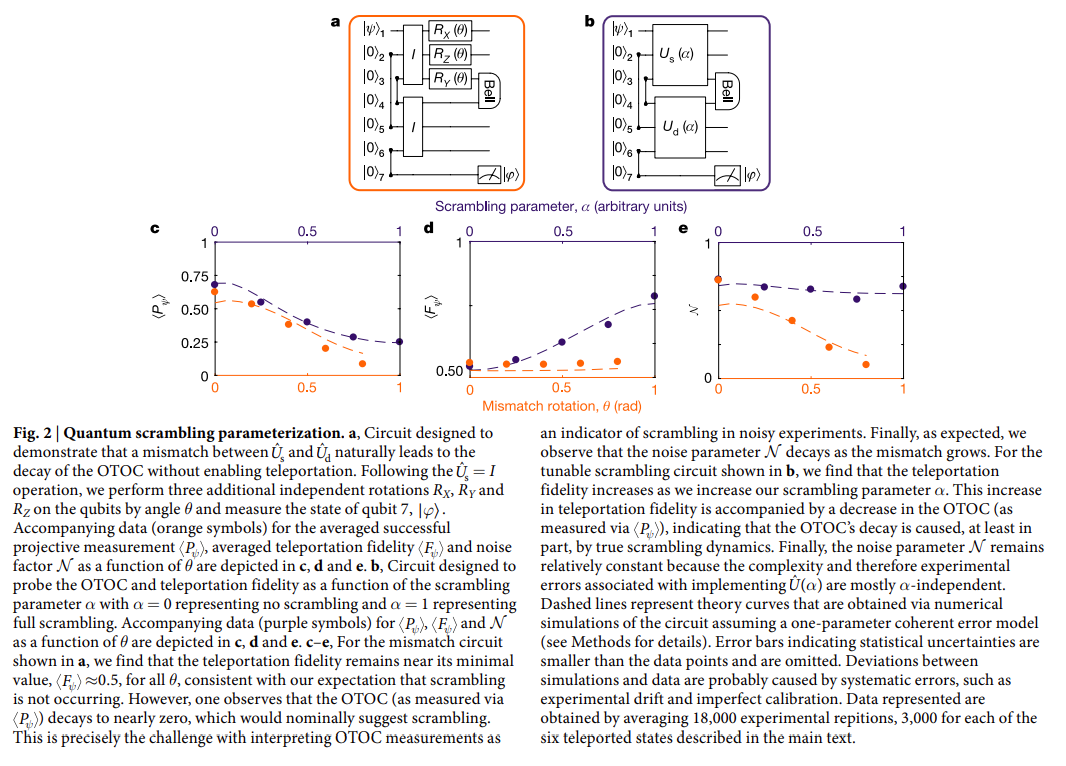

# Generate Random Unitary for Adding Error

In [3]:

def random_unitary(gate_size : int, epsilon : float):

    # For one-qubit gates, gate_size is 1, and for two-qubit gates, it is 2. 
    # The error strength (standard deviation) is denoted by epsilon.

    from qiskit.quantum_info import Pauli, Operator
    from scipy.linalg import expm
    import numpy as np

    # Defining the standard_deviation value 
    standard_deviation = epsilon / np.sqrt(3) if gate_size == 1 else epsilon / np.sqrt(15)
    

    if gate_size == 1:

        # The four Pauli operators are as follows. 
        # Pauli("X"), Pauli("Y"), Pauli("Z"), and Pauli ("I")

        # Set of Pauli operators for one-qubit gates pauli_set.
        # linear combination of these Pauli matrix will give a 
        # unitary matrix which is close to identity matrtix. 
        # Here we have use only 'X', 'Y' and 'Z' because we need 
        # a unitary for error which has the dimention of 2 X 2.
        # We neglect 'I' because it doesn't alter the state of the system.
        pauli_set = [Pauli("X"), Pauli("Y"), Pauli("Z")]

        # This generates coefficients for the above Pauli operators. 
        # generates three random value from the normal / Gaussian distribution 
        coefficients = np.random.normal(0, standard_deviation, size=3)

        # This gives the sum of the all the Pauli matrix multiplied 
        # which their respective coefficients. 
        matrix = sum(coefficient * pauli.to_matrix() for coefficient, pauli in zip(coefficients,pauli_set))


    elif gate_size == 2:

        # Set of Pauli operators for two-qubit gates pauli_set. 
        # Here we have use only 'XI', 'YI' and 'ZI' and so on  because we need 
        # a unitary for error which has the dimention of 4 X 4.
        # We neglect 'II' because it doesn't alter the state of the system.
        pauli_set = [
            Pauli("XI"), Pauli("YI"), Pauli("ZI"),
            Pauli("IX"), Pauli("IY"), Pauli("IZ"),
            Pauli("XX"), Pauli("XY"), Pauli("XZ"),
            Pauli("YX"), Pauli("YY"), Pauli("YZ"),
            Pauli("ZX"), Pauli("ZY"), Pauli("ZZ")
        ]

        # This generates coefficients for the above Pauli operators. 
        # generates fifteen random value from the normal / Gaussian distribution 
        coefficients = np.random.normal(0, standard_deviation, size=15)

        # This gives the sum of the all the Pauli matrix multiplied 
        # which their respective coefficients. 
        matrix = sum(coefficient * pauli.to_matrix() for coefficient, pauli in zip(coefficients,pauli_set))

    else:
        # This only generates error for only one qubit and two qubit quantum gates.
        raise ValueError(f"Expected number of qubits to be 1 or 2 but '{gate_size}' were given")
    
    # This calculates the exponent of the linear combination of the matrix
    exponent_matrix = expm(1j * matrix)

    # Converting the matix to the operator
    unitary = Operator(exponent_matrix)
    
    # returns the unitary operator for error
    return unitary

# Unitary Used in the Above Circuit

In [4]:
# This is the unitary circuit used in the paper to produce the graph. 
# Which is unitary replaced by -unitary
# If we replace the rxx_value with - rxx_value and theta with - theta, 
# it can reproduce the matrix mentioned in the paper. 
# This unitary will only take two qubit error operators
def unitary(alpha : float, error : Operator):

    # the value should be pi/4 but in new RXX gate 
    # definition the value of theta is taken as theta/2
    # here either both rxx_value and theta should be negative 
    # or positve to reproduce the matix mentioned in the paper
    rxx_value = np.pi/2 
    theta = (alpha)*(np.pi/2)


    circuit = QuantumCircuit(3)

    circuit.rxx(-rxx_value,0,1)
    circuit.append(error, [0,1])
    circuit.rxx(-rxx_value,0,2)
    circuit.append(error, [0,2])
    circuit.rxx(-rxx_value,1,2)
    circuit.append(error, [1,2])

    circuit.rz(-theta,0)
    circuit.rz(-theta,1)
    circuit.rz(-theta,2)

    circuit.rxx(-rxx_value,0,1)
    circuit.append(error, [0,1])
    circuit.rxx(-rxx_value,0,2)
    circuit.append(error, [0,2])
    circuit.rxx(-rxx_value,1,2)
    circuit.append(error, [1,2])

    circuit.rz(theta,0)
    circuit.rz(theta,1)
    circuit.rz(theta,2)

    return Operator(circuit)

# To check the form of the unitary without any error involved. 
# To do this we need to set the error parameter to 0. Error 
# parameter should be 0.232 (for mismatch angle calculation) 
# and 0.174 (for the calculation of the scrambling properties)
two_qubit_error = random_unitary(2, 0)

# To verify the unitary is taking the expected form or not. 
# Here we are negleting the overall phase factor -1j
unitary_operator = unitary(1, two_qubit_error)
print("Unitary without any error(ideal unitary)")
unitary_operator.draw('latex', prefix="U_{s}= ")

Unitary without any error(ideal unitary)


<IPython.core.display.Latex object>

# Veryfying the Scrambling Property of the matrix

In [5]:
from qiskit.quantum_info import Pauli, Operator
import numpy as np

# This is to verify that the unitary's scrambling property
# that is the unitary should delocolaize all the single qubit 
# Pauli operation into three qubit Pauli operator. 


# Pauli_idenity is a set of single qubit Pauli operators 
# which is being multiplied by two Pauli operator 'I'. 
# This is to match the dimentions of the unitary and this can 
# done in  three different ways for each of the Pauli operators.  
pauli_identity = [
    Pauli('XII'), Pauli('IXI'), Pauli('IIX'),
    Pauli('YII'), Pauli('IYI'), Pauli('IIY'),
    Pauli('ZII'), Pauli('IZI'), Pauli('IIZ')
    ]

# Pauli_set is a set of three qubit Pauli operators. 
# In which any two of the three operators will be same.
pauli_set = [
    Pauli('XZZ'), Pauli('ZXZ'), Pauli('ZZX'),
    Pauli('YXX'), Pauli('XYX'), Pauli('XXY'),
    Pauli('ZYY'), Pauli('YZY'), Pauli('YYZ')
    ]

# As we define the uniatry circuit with error we need to add 
# the error to it. This can also be done without error as well. 
# To do so we add identity operator as error. 
# This is eqvalent to the case where there is no error.
two_qubit_error = random_unitary(2, 0) 

# Generating the unitary
U = unitary(1, two_qubit_error)
display(U.draw('latex', prefix="U_{s}= "))


# Generating the complex conjugate transpose of the unitary
U_dagger = U.conjugate().transpose()
U_t = Operator(U_dagger)
display(U_t.draw('latex', prefix="U_{s}^{\\dagger}= "))


# Checking the Scrambling property of the unitary 
for identity , set in zip(pauli_identity,pauli_set):

    lhs = U_t @ identity.to_matrix() @ U
    #display(lhs.draw('latex'))

    rhs = Operator(set.to_matrix())
    #display(rhs.draw('latex'))

    # This will check for equivalent up to a global phase factor
    if lhs.equiv(rhs):
        print(f"{identity} is equal to {set}") 

    # This wont work when there is a global phase factor
    #print("Equal") if lhs == rhs else print("Something Wrong") 

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

XII is equal to XZZ
IXI is equal to ZXZ
IIX is equal to ZZX
YII is equal to YXX
IYI is equal to XYX
IIY is equal to XXY
ZII is equal to ZYY
IZI is equal to YZY
IIZ is equal to YYZ


In [6]:
# This is the teleportation circuit which take the uniatry matrix as identity
# This function is defined with two errors one_qubit_error adds the error 
# to all the gates which is being acting on a single qubit. 
# simiarly two_qubit_error adds the error to all the two qubits gates. 
# Theta here takes the value from 0 to 3.14 and while plotting it has to be normalized.
def teleportation_identity(theta : float, one_qubit_error : Operator, two_qubit_error : Operator):
    
    teleportation = QuantumCircuit(7,2)

    # Creating the bell pair RXXGate and rz rotation
    for bell in [(1,4),(2,3),(5,6)]:

        # use + for both np.pi / 2 or use - for both
        teleportation.append(RXXGate(np.pi / 2), [bell[0], bell[1]])
        teleportation.append(two_qubit_error, [bell[0], bell[1]])

        # we neglect the error caused in rotation in which rz is perfomed accoding 
        # to the paper. Becouse they have performed this with neglable errors. 
        teleportation.rz(np.pi / 2, bell[0])

    # adding Scrambling unitary
    teleportation.append(unitary(0 , two_qubit_error), [0,1,2])


    # performing the rotations and adding the error involved
    teleportation.rx(theta, 0)
    teleportation.append(one_qubit_error, [0])
    teleportation.rz(theta, 1)
    teleportation.ry(theta, 2)
    teleportation.append(one_qubit_error, [2])

    # adding the decoding unitary
    teleportation.append(unitary(0, two_qubit_error).adjoint(), [3,4,5])        

    # This will returns the teleportation circuit
    return teleportation

#single_qubit_error = random_unitary(1, 0)
#two_qubit_error = random_unitary(2, 0)
#tel = teleportation_identity(0, single_qubit_error, two_qubit_error)
#tel.draw()

In [7]:
# This teleportation circuit take the Scrambling uniatry matrix for teleportation.
# This function is defined with two errors one_qubit_error adds the error 
# to all the gates which is being acting on a single qubit. 
# simiarly two_qubit_error adds the error to all the two qubits gates.
# alpha (scrambling parameter) here takes the value form 0 to 1.
def teleportation_scrambling(alpha : float, one_qubit_error, two_qubit_error):

    teleportation = QuantumCircuit(7,2)

    for bell in [(1,4),(2,3),(5,6)]:

        teleportation.append(RXXGate(np.pi / 2), [bell[0], bell[1]])
        teleportation.append(two_qubit_error, [bell[0], bell[1]])
        
        teleportation.rz(np.pi/2, bell[0])

    # adding Scrambling unitary
    teleportation.append(unitary(alpha, two_qubit_error),[0,1,2])

    # adding the decoding unitary
    teleportation.append(unitary(alpha, two_qubit_error).adjoint() ,[3,4,5])

    # This will returns the teleportation circuit
    return teleportation

In [8]:
# This is classical scrambling uniatry define in the circuit.
def classical_unitary(alpha : float, one_qubit_error, two_qubit_error):
    circuit = QuantumCircuit(3)

    for cs in [(0,2),(1,2),(0,1)]:
        circuit.cz(cs[0],cs[1])
        circuit.append(two_qubit_error, [cs[0],cs[1]])
   
    return Operator(circuit)

#circuit_matrix = classical_unitary()
#circuit_matrix.draw('latex')

In [9]:
def classical_scrambling(alpha : float , one_qubit_error, two_qubit_error):

    teleportation = QuantumCircuit(7,2)

    for bell in [(1,4),(2,3),(5,6)]:

        teleportation.append(RXXGate(np.pi / 2), [bell[0], bell[1]])
        teleportation.append(two_qubit_error, [bell[0], bell[1]])
        
        teleportation.rz(np.pi/2, bell[0])

    # adding Scrambling unitary
    teleportation.append(unitary(alpha, two_qubit_error),[0,1,2])

    # adding the decoding unitary
    teleportation.append(unitary(alpha, two_qubit_error).adjoint() ,[3,4,5])

    return teleportation

# Calculation of Projective Measurement Probability for Identity Unitary

Probability of the state '0' is : [0.109, 0.11933, 0.11567, 0.117, 0.12633, 0.11767, 0.11667, 0.10167, 0.10367, 0.09367, 0.09367]
Probability of the state '1' is : [0.31133, 0.29867, 0.30433, 0.28667, 0.27333, 0.24633, 0.214, 0.19467, 0.157, 0.14533, 0.11833]
Probability of the state '+' is : [0.22867, 0.23633, 0.24867, 0.23133, 0.21967, 0.203, 0.17933, 0.16367, 0.14533, 0.11267, 0.09767]
Probability of the state '-' is : [0.15267, 0.164, 0.17233, 0.16067, 0.181, 0.16067, 0.14567, 0.14367, 0.13, 0.12667, 0.10733]
Probability of the state 'r' is : [0.15967, 0.17333, 0.16233, 0.158, 0.17267, 0.16733, 0.159, 0.154, 0.133, 0.12133, 0.10967]
Probability of the state 'l' is : [0.23667, 0.225, 0.24633, 0.23067, 0.21733, 0.19867, 0.18733, 0.144, 0.13133, 0.108, 0.099]
Avg <probability> for error 1 : [0.19967, 0.20278, 0.20828, 0.19739, 0.19839, 0.18228, 0.167, 0.15028, 0.13339, 0.11794, 0.10428]
Probability of the state '0' is : [0.39133, 0.36867, 0.34967, 0.292, 0.25767, 0.19667, 0.14167, 0.1

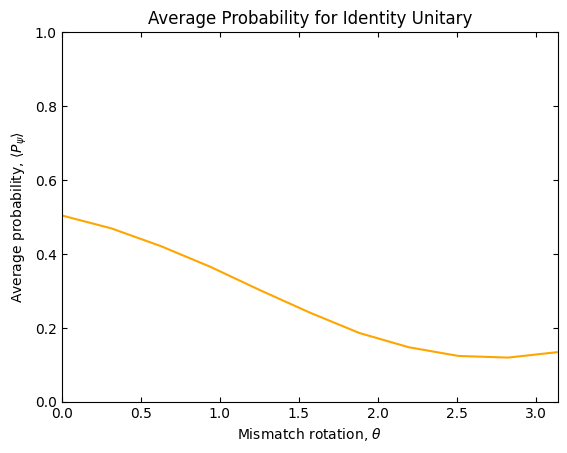

In [10]:
# Averaged over all the eigenstates of the Pauli operators 
# for 10 different errors. They have sampled it for 3000 
# times do the number of counts (shots)is defined as 3000
probability = [] 
shots = 3000 

# Mismatch parameter theta runs from 0 to 3.14 which is normalized for plotting.
# angle = [0.0, 0.314, 0.628, 0.942, 1.256, 1.57, 1.884, 2.198, 2.512, 2.826, 3.14]
normalization = [round(num, 2) for num in np.arange(0.0, 1.0 + 0.1, 0.1).tolist()]
angle = [round(num * (3.14 - 0) + 0, 3) for num in normalization]


# Averaging for 10 different random unitary errors. 
# This generates different value of random error each time
for i in range(10):


    # generating errors
    single_qubit_error = random_unitary(1, 0.232)
    two_qubit_error = random_unitary(2, 0.232)


    # This average_probability list stores all the value of the 
    # probability this is generated for all the six eigenstates 
    # of the Pauli matrix.  
    average_probability = []


    # This will generate all the eigenstates of the Pauli operator  
    for state in ['0', '1', '+', '-', 'r', 'l']: 
        if state == 'r':
            initial_state = Statevector([1/np.sqrt(2), 1j/np.sqrt(2)])
        elif state == 'l':
            initial_state = Statevector([1/np.sqrt(2), -1j/np.sqrt(2)])
        else:
            initial_state = Statevector.from_label(state)
        

        # This state_probability collects all the probability of the successful 
        # projection value for each theta for a particular Pauli operator eigenstate.
        state_probability = []
        

        # This loop claculates the probability of the successful projection for 
        # each value of the theta defined in the list angle.
        for theta in angle: 

            # Generating a quantum circuit and initializing it with the desied 
            # Pauli operator eigenstate
            ckt = QuantumCircuit(7,2)
            ckt.initialize(initial_state,[0])

            # This adds the teleportation circuit in place
            ckt.compose(teleportation_identity(theta, single_qubit_error, two_qubit_error ), inplace=True)

            # To do projective measurement we apply rz gate followed by RXXXGate after that we make 
            # the bell measurement on the desired qubits and store them in the classical bits.
            ckt.rz(np.pi/2, 2)
            ckt.append(RXXGate(np.pi / 2), [2,3])
            ckt.append(two_qubit_error,[2,3])
            ckt.measure([2,3],[0,1])
            

            # run the circuit in the simulator for sampling counts equal to 3000.
            simulator = Aer.get_backend('qasm_simulator')
            compile = transpile(ckt, simulator)
            output = simulator.run(compile, shots=shots).result()

            # counts is a dictionary that stores the experiment result
            counts = output.get_counts() 
            

            success = 0
            # This extracts all the number of count for different projection ['00', '01', '10', '11'].
            # But the successful projection is only '00' we need to extract the count of that 
            # projection only. The value will bw stored in the variable success.
            for projection in counts:
                if projection[:2] == '00':
                    success = counts[projection]

                    # To collects the probability of the successful projection for different values 
                    # of theta, we need to divide the success count by the total number of sampling.
                    state_probability.append(round((success / shots),5)) 
                    
        # This will print the probability fo the each state 
        print(f"Probability of the state '{state}' is : {state_probability}")

        # Collects the probability of the each states (six Pauli eigenstates) and then 
        # append them in the average_probability list.
        average_probability.append(state_probability)
        

    # To generate the average probability of all the six states for one cycle of error, we 
    # take the mean beased on the index of the list and add that to the list probability.
    # final_probability is averaged for all the six eigenstates
    final_probability = np.round(np.mean(average_probability, axis=0),decimals=5).tolist()
    print(f"Avg <probability> for error {i+1} : {final_probability}")
    probability.append(final_probability)


    # This will plot the averaged probability claculated for each error in a single graph
    """
    plt.plot(angle, final_probability, scaley=True)
    plt.xlabel("Mismatch rotation, $\\theta$")
    plt.ylabel("Average probability, $\\langle P_{\\psi} \\rangle$")
    plt.tick_params(direction ='in', bottom=True, top=True, left=True, right=True)
    plt.title("Average Probability for Identity Unitary")
    """
    

   
# To plot the overall averaged probability of the successfull projection we need to average
# all the collected averaged probability for each individual error and then we have to plot 
# it. identity_probability calculatd the overall average for all ten random errors. 
identity_probability = np.round(np.mean(probability, axis=0), decimals=5).tolist()
print(f"Overall <probability> for 10 errors : {identity_probability}")


# To plot the overall probability of the successfull projection.
plt.plot(angle, identity_probability, color = "orange" , scalex=False, scaley=False)
plt.xlim(0,3.14)
plt.xlabel("Mismatch rotation, $\\theta$")
plt.ylabel("Average probability, $\\langle P_{\\psi} \\rangle$")
plt.tick_params(direction ='in', bottom=True, top=True, left=True, right=True)
plt.title("Average Probability for Identity Unitary")
plt.show() 

# Calculation of Projective Measurement Probability for Scrambling Unitary

Probability of the state '0' is : [0.76633, 0.75967, 0.71033, 0.61333, 0.52167, 0.436, 0.351, 0.28167, 0.249, 0.22533, 0.22567]
Probability of the state '1' is : [0.74267, 0.71533, 0.67933, 0.587, 0.531, 0.43667, 0.36933, 0.31467, 0.27467, 0.27267, 0.26833]
Probability of the state '+' is : [0.75, 0.744, 0.69033, 0.61567, 0.53667, 0.431, 0.35233, 0.282, 0.25267, 0.23367, 0.236]
Probability of the state '-' is : [0.78433, 0.76067, 0.69233, 0.58067, 0.51, 0.42533, 0.357, 0.299, 0.27833, 0.274, 0.27067]
Probability of the state 'r' is : [0.75933, 0.75067, 0.70367, 0.61833, 0.53633, 0.45767, 0.37267, 0.331, 0.28733, 0.27367, 0.28033]
Probability of the state 'l' is : [0.75267, 0.738, 0.68467, 0.591, 0.50567, 0.436, 0.33, 0.28467, 0.235, 0.23367, 0.235]
Avg <probability> for error 1 : [0.75922, 0.74472, 0.69344, 0.601, 0.52356, 0.43711, 0.35539, 0.29883, 0.26283, 0.25217, 0.25267]
Probability of the state '0' is : [0.868, 0.804, 0.695, 0.59433, 0.49167, 0.40533, 0.33533, 0.28533, 0.27267, 0

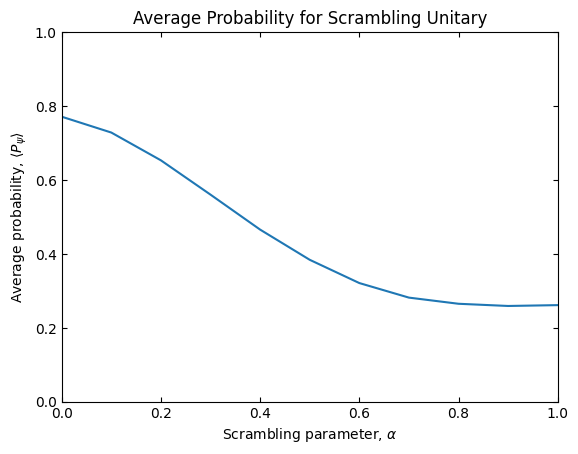

In [11]:
# Averaged over all the eigenstates of the Pauli operators 
# for 10 different errors. They have sampled it for 3000 
# times do the number of counts (shots)is defined as 3000
probability = [] 
shots=3000

# Values of the scrambling parameter alpha
# scrambling_parameter = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
scrambling_parameter = np.arange(0.0, 1.0 +0.1, 0.1).tolist()


# Averaging for 10 different random unitary errors. 
# This generates different value of random error each time
for i in range(10):

    # generating errors
    single_qubit_error = random_unitary(1, 0.174)
    two_qubit_error = random_unitary(2, 0.174)


    # This average_probability list stores all the value of the 
    # probability this is generated for all the six eigenstates 
    # of the Pauli matrix. 
    average_probability = []

    # This will generate all the eigenstates of the Pauli operator  
    for state in ['0', '1', '+', '-', 'r', 'l']:  # [ |0⟩, |1⟩, |+⟩, |−⟩, |i+⟩, |i−⟩ ]
        if state == 'r':
            initial_state = Statevector([1/np.sqrt(2), 1j/np.sqrt(2)])
        elif state == 'l':
            initial_state = Statevector([1/np.sqrt(2), -1j/np.sqrt(2)])
        else:
            initial_state = Statevector.from_label(state)
        

        # This state_probability collects all the probability of the successful 
        # projection value for each theta for a particular Pauli operator eigenstate.
        state_probability = []


        # This loop claculates the probability of the successful projection for 
        # each value of the alpha defined in the list scrambling_parameter.
        for alpha in scrambling_parameter:

            # Generating a quantum circuit and initializing it with the desied 
            # Pauli operator eigenstate
            ckt = QuantumCircuit(7,2)
            ckt.initialize(initial_state,[0])

            # This adds the teleportation circuit in place
            ckt.compose(teleportation_scrambling(alpha, single_qubit_error, two_qubit_error), inplace=True)

            # To do projective measurement we apply rz gate followed by RXXXGate after that we make 
            # the bell measurement on the desired qubits and store them in the classical bits.
            ckt.rz(np.pi/2, 2)
            ckt.append(RXXGate(np.pi / 2), [2,3])
            ckt.append(two_qubit_error,[2,3])
            ckt.measure([2,3],[0,1])


            # run the circuit in the simulator for sampling counts equal to 3000.
            simulator = Aer.get_backend('qasm_simulator')
            compile = transpile(ckt, simulator)
            output = simulator.run(compile, shots=shots).result()

            # counts is a dictionary that stores the experiment result
            counts = output.get_counts()

            success = 0
            # This extracts all the number of count for different projection ['00', '01', '10', '11'].
            # But the successful projection is only '00' we need to extract the count of that 
            # projection only. The value will bw stored in the variable success.
            for projection in counts:
                if projection[:2] == '00':
                    success = counts[projection]

                    # To collects the probability of the successful projection for different values 
                    # of theta, we need to divide the success count by the total number of sampling.
                    state_probability.append(round((success / shots),5))

        # This will print the probability fo the each state 
        print(f"Probability of the state '{state}' is : {state_probability}")

        # Collects the probability of the each states (six Pauli eigenstates) and then 
        # append them in the average_probability list.
        average_probability.append(state_probability)



    # To generate the average probability of all the six states for one cycle of error, we 
    # take the mean beased on the index of the list and add that to the list probability.
    # final_probability is averaged for all the six eigenstates
    final_probability = np.round(np.mean(average_probability, axis=0),decimals=5).tolist()
    print(f"Avg <probability> for error {i+1} : {final_probability}")
    probability.append(final_probability)


    # This will plot the averaged probability claculated for each error in a single graph
    """ 
    plt.plot(scrambling_parameter, final_probability, scaley=False, scalex=False)
    plt.xlabel("Scrambling parameter,  $\\alpha$")
    plt.ylabel("Average probability, $\\langle P_{\\psi} \\rangle$")
    plt.tick_params(direction ='in', bottom=True, top=True, left=True, right=True)
    plt.title("Average Probability for Scrambling Unitary")
    """
    
# To plot the overall averaged probability of the successfull projection we need to average
# all the collected averaged probability for each individual error and then we have to plot 
# it. scrambling_probability calculatd the overall average for all ten random errors. 
scrambling_probability = np.round(np.mean(probability, axis=0), decimals=5).tolist()
print(f"Overall <probability> for 10 errors : {scrambling_probability}")

# To plot the overall probability of the successfull projection.
plt.plot(scrambling_parameter, scrambling_probability, scaley=False, scalex=False)
plt.xlabel("Scrambling parameter, $\\alpha$")
plt.ylabel("Average probability, $\\langle P_{\\psi} \\rangle$")
plt.tick_params(direction ='in', bottom=True, top=True, left=True, right=True)
plt.title("Average Probability for Scrambling Unitary")
plt.show()

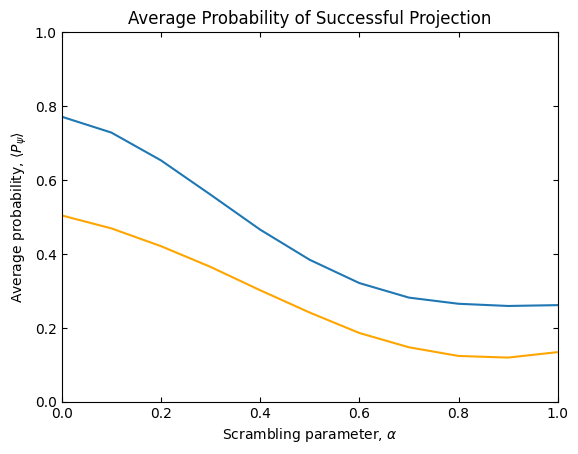

In [12]:
plt.plot(scrambling_parameter, scrambling_probability, scaley=False, scalex=False)
plt.plot(scrambling_parameter, identity_probability, color = "orange" , scalex=False, scaley=False)
plt.xlabel("Scrambling parameter, $\\alpha$")
plt.ylabel("Average probability, $\\langle P_{\\psi} \\rangle$")
plt.tick_params(direction ='in', bottom=True, top=True, left=True, right=True)
plt.title("Average Probability of Successful Projection")
plt.show()

# Fidelity Calculation for Identity Unitary

Fidelity of the state '0' is : [0.67315, 0.68206, 0.44286, 0.46211, 0.68307, 0.20786, 0.58312, 0.61003, 0.29519, 0.32825, 0.66204]
Fidelity of the state '1' is : [0.5572, 0.34174, 0.33895, 0.46494, 0.55105, 0.71835, 0.36671, 0.47604, 0.53315, 0.39535, 0.37864]
Fidelity of the state '+' is : [0.55123, 0.56013, 0.55483, 0.55891, 0.56199, 0.56395, 0.50558, 0.52036, 0.53945, 0.5461, 0.55938]
Fidelity of the state '-' is : [0.4481, 0.57314, 0.42599, 0.46342, 0.45135, 0.43978, 0.47365, 0.5313, 0.4597, 0.49983, 0.48628]
Fidelity of the state 'r' is : [0.50727, 0.28762, 0.54593, 0.3277, 0.27726, 0.57692, 0.35129, 0.29677, 0.32059, 0.43603, 0.50388]
Fidelity of the state 'l' is : [0.54909, 0.64905, 0.51707, 0.66671, 0.49407, 0.67874, 0.66016, 0.68211, 0.61535, 0.59272, 0.60617]
Avg <fidelity> for error 1 : [0.54767, 0.51562, 0.47094, 0.49063, 0.50313, 0.53093, 0.49009, 0.51944, 0.46057, 0.46638, 0.53273]
Fidelity of the state '0' is : [0.52566, 0.58495, 0.51638, 0.48517, 0.50254, 0.49155, 0.541

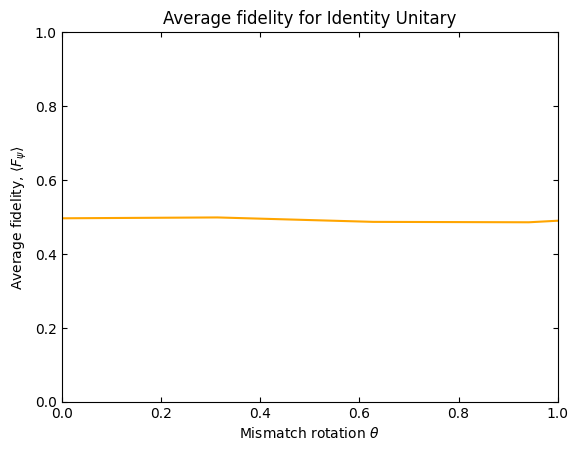

In [13]:
# Averaged over all the eigenstates of the Pauli operators 
# for 10 different errors. They have sampled it for 3000 
# times do the number of counts (shots)is defined as 3000
fidelity = [] 
shots = 3000

# Mismatch parameter theta runs from 0 to 3.14 which is normalized for plotting.
# angle = [0.0, 0.314, 0.628, 0.942, 1.256, 1.57, 1.884, 2.198, 2.512, 2.826, 3.14]
normalization = [round(num, 2) for num in np.arange(0.0, 1.0 + 0.1, 0.1).tolist()]
angle = [round(num * (3.14 - 0) + 0, 3) for num in normalization]

# Averaging for 10 different random unitary errors. 
# This generates different value of random error each time
for i in range(10):


    # generating errors
    single_qubit_error = random_unitary(1, 0.232)
    two_qubit_error = random_unitary(2, 0.232)

    # This average_fidelity list stores all the value of the 
    # fidelity this is generated for all the six eigenstates 
    # of the Pauli matrix.  
    average_fidelity = []

    # This will generate all the eigenstates of the Pauli operator
    for state in ['0', '1', '+', '-', 'r', 'l']: 
        if state == 'r':
            initial_state = Statevector([1/np.sqrt(2), 1j/np.sqrt(2)])
        elif state == 'l':
            initial_state = Statevector([1/np.sqrt(2), -1j/np.sqrt(2)])
        else:
            initial_state = Statevector.from_label(state)
        

        # This each_state_fidelity collects all the fidelity for the the successful 
        # projection for each value of theta for a particular Pauli operator eigenstate.
        each_state_fidelity = []

        # This loop claculates the fidelity of the successful projection for 
        # each value of the theta defined in the list angle.
        for theta in angle: 

            # Generating a quantum circuit and initializing it with the desied 
            # Pauli operator eigenstate
            ckt = QuantumCircuit(7,2)
            ckt.initialize(initial_state,[0])

            # This adds the teleportation circuit in place
            ckt.compose(teleportation_identity(theta, single_qubit_error, two_qubit_error), inplace=True)

            # To do projective measurement we apply rz gate followed by RXXXGate after that we make 
            # the bell measurement on the desired qubits and store them in the classical bits.
            ckt.rz(np.pi/2, 2)
            ckt.append(RXXGate(np.pi / 2), [2,3])
            ckt.append(two_qubit_error,[2,3])
            # Measuring the Bell Pair (qubit-2 ans qubit-3)
            ckt.measure([2,3],[0,1])

            # run the circuit in the simulator for sampling counts equal to 3000.
            simulator = Aer.get_backend('qasm_simulator')
            compile = transpile(ckt, simulator)
            output = simulator.run(compile, shots=shots).result()

            # counts is a dictionary that stores the experiment result
            counts = output.get_counts()

            success = 0
            # This extracts all the number of count for different projection ['00', '01', '10', '11'].
            # But the successful projection is only '00' we need to extract the count of that 
            # projection only. The value will bw stored in the variable success.
            for projection in counts:
                if projection[:2] == '00':
                    success += counts[projection]

                    # this creates a copy of the teleportation circuit and saves the statevector of the circuit
                    inner_ckt = ckt.copy()
                    inner_ckt.save_statevector()
                    # Get the statevector to calculate the fidelity
                    #simulator = Aer.get_backend('statevector_simulator')
                    #compile = transpile(inner_ckt, simulator)
                    inner_output = simulator.run(inner_ckt).result()
                    statevector = inner_output.get_statevector()
                    # Tracing out the statevector of the qubit-6
                    final_state = partial_trace(statevector,[0,1,2,3,4,5])

                    each_state_fidelity.append(round(state_fidelity(initial_state, final_state),5))
        average_fidelity.append(each_state_fidelity)

    
        print(f"Fidelity of the state '{state}' is : {each_state_fidelity}")
        
    # To generate the average probability of all the six states for one cycle of error, we 
    # take the mean beased on the index of the list and add that to the list probability.
    # final_probability is averaged for all the six eigenstates
    final_fidelity = np.round(np.mean(average_fidelity, axis=0), decimals=5).tolist()
    print(f"Avg <fidelity> for error {i+1} : {final_fidelity}")
    fidelity.append(final_fidelity)

    # This will plot the averaged probability claculated for each error in a single graph
    """
    plt.plot(angle, final_fidelity, scalex=False, scaley=False)
    plt.xlabel("Mismatch rotation, $\\theta$")
    plt.ylabel("Average fidelity, $\\langle P_{\\psi} \\rangle$")
    plt.tick_params(direction ='in', bottom=True, top=True, left=True, right=True)
    plt.title("Average fidelity for Identity Unitary")
    """


# To plot the overall averaged probability of the successfull projection we need to average
# all the collected averaged probability for each individual error and then we have to plot 
# it. identity_probability calculatd the overall average for all ten random errors.     
identity_fidelity = np.round(np.mean(fidelity, axis=0), decimals=5).tolist()
print(f"Overall <fidelity> for 10 errors : {identity_fidelity}")


plt.plot(angle, identity_fidelity, scaley=False, scalex=False , color= "orange")
plt.xlabel("Mismatch rotation $\\theta$")
plt.ylabel("Average fidelity, $\\langle F_{\\psi} \\rangle$")
plt.tick_params(direction ='in', bottom=True, top=True, left=True, right=True)
plt.title("Average fidelity for Identity Unitary")
plt.show()

# Fidelity Calculation for Scrambling Unitary

Fidelity of the state '0' is : [0.46373, 0.50619, 0.47353, 0.39151, 0.49249, 0.49508, 0.48985, 0.40538, 0.4949, 0.40163, 0.38296]
Fidelity of the state '1' is : [0.54533, 0.54647, 0.41154, 0.39734, 0.59982, 0.50382, 0.40061, 0.57827, 0.65317, 0.39448, 0.63883]
Fidelity of the state '+' is : [0.35269, 0.40311, 0.26226, 0.23079, 0.2161, 0.51645, 0.51601, 0.42172, 0.44694, 0.43265, 0.3768]
Fidelity of the state '-' is : [0.37291, 0.60539, 0.57962, 0.65753, 0.68432, 0.69961, 0.5602, 0.58237, 0.48663, 0.49473, 0.51836]
Fidelity of the state 'r' is : [0.47491, 0.47439, 0.45877, 0.48368, 0.49489, 0.45608, 0.45425, 0.49465, 0.50625, 0.36672, 0.44247]
Fidelity of the state 'l' is : [0.53214, 0.51347, 0.53033, 0.53386, 0.5418, 0.54828, 0.54295, 0.43723, 0.4479, 0.54132, 0.51088]
Avg <fidelity> for error 1 : [0.45695, 0.50817, 0.45268, 0.44912, 0.5049, 0.53655, 0.49398, 0.4866, 0.50597, 0.43859, 0.47838]
Fidelity of the state '0' is : [0.48742, 0.46765, 0.52265, 0.22414, 0.58232, 0.28339, 0.61941

'The final fidelity is : [0.49276, 0.4941, 0.49857, 0.47415, 0.49256, 0.5097, 0.49047, 0.49175, 0.50846, 0.48649, 0.51064]'

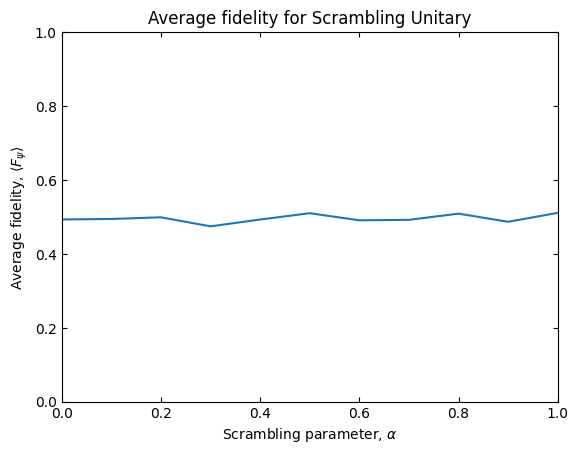

In [14]:
# Averaged over all the eigenstates of the Pauli operators 
# for 10 different errors. They have sampled it for 3000 
# times do the number of counts (shots)is defined as 3000
fidelity = []
shots=3000 

# Values of the mismatch parameter theta 
# scrambling_parameter = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
scrambling_parameter = np.arange(0.0, 1.0 +0.1, 0.1).tolist()

# Averaging for 10 different random unitary errors. 
# This generates different value of random error each time
for i in range(10):


    # generating errors
    single_qubit_error = random_unitary(1, 0.174)
    two_qubit_error = random_unitary(2, 0.174)

    # This average_fidelity list stores all the value of the 
    # fidelity this is generated for all the six eigenstates 
    # of the Pauli matrix. 
    average_fidelity = []

    # This will generate all the eigenstates of the Pauli operator
    for state in ['0', '1', '+', '-', 'r', 'l']:  # [ |0⟩, |1⟩, |+⟩, |−⟩, |i+⟩, |i−⟩ ]
        if state == 'r':
            initial_state = Statevector([1/np.sqrt(2), 1j/np.sqrt(2)])
        elif state == 'l':
            initial_state = Statevector([1/np.sqrt(2), -1j/np.sqrt(2)])
        else:
            initial_state = Statevector.from_label(state)
        
        # This each_state_fidelity collects all the fidelity for the the successful 
        # projection for each value of theta for a particular Pauli operator eigenstate.
        each_state_fidelity = []

        # This loop claculates the probability of the successful projection for 
        # each value of the alpha defined in the list scrambling_parameter.
        for alpha in scrambling_parameter:

            # Generating a quantum circuit and initializing it with the desied 
            # Pauli operator eigenstate
            ckt = QuantumCircuit(7,2)
            ckt.initialize(initial_state,[0])

            # This adds the teleportation circuit in place
            ckt.compose(teleportation_scrambling(alpha, single_qubit_error, two_qubit_error), inplace=True)

            # To do projective measurement we apply rz gate followed by RXXXGate after that we make 
            # the bell measurement on the desired qubits and store them in the classical bits.
            ckt.rz(np.pi/2, 2)
            ckt.append(RXXGate(np.pi / 2), [2,3])
            ckt.append(two_qubit_error,[2,3])
            # Measuring the Bell Pair (qubit-2 ans qubit-3)
            ckt.measure([2,3],[0,1])

            # run the circuit in the simulator for sampling counts equal to 3000.
            simulator = Aer.get_backend('qasm_simulator')
            compile = transpile(ckt, simulator)
            output = simulator.run(compile, shots=shots).result()

            # counts is a dictionary that stores the experiment result
            counts = output.get_counts()

            success = 0
            # This extracts all the number of count for different projection ['00', '01', '10', '11'].
            # But the successful projection is only '00' we need to extract the count of that 
            # projection only. The value will bw stored in the variable success.
            for projection in counts:
                if projection[:2] == '00':
                    success += counts[projection]

                    # this creates a copy of the teleportation circuit and saves the statevector of the circuit
                    inner_ckt = ckt.copy()
                    inner_ckt.save_statevector()
                    # Get the statevector to calculate the fidelity
                    #simulator = Aer.get_backend('statevector_simulator')
                    #compile = transpile(inner_ckt, simulator)
                    inner_output = simulator.run(inner_ckt).result()
                    statevector = inner_output.get_statevector()
                    # Tracing out the statevector of the qubit-6
                    final_state = partial_trace(statevector,[0,1,2,3,4,5])

                    #fidelity.append(np.abs(np.dot(initial_state.data.conj(), final_state.data))**2)
                    each_state_fidelity.append(round(state_fidelity(initial_state, final_state),5))
        average_fidelity.append(each_state_fidelity)


        print(f"Fidelity of the state '{state}' is : {each_state_fidelity}")

    # To generate the average probability of all the six states for one cycle of error, we 
    # take the mean beased on the index of the list and add that to the list probability.
    # final_probability is averaged for all the six eigenstates
    final_fidelity = np.round(np.mean(average_fidelity, axis=0), decimals=5).tolist()
    print(f"Avg <fidelity> for error {i+1} : {final_fidelity}")
    fidelity.append(final_fidelity)

    # To plot the result of all the averaged fidelity
    """
    plt.plot(scrambling_parameter, final_fidelity, scalex=False, scaley=False)
    plt.xlabel("Scrambling parameter, $\\alpha$")
    plt.ylabel("Average fidelity, $\\langle P_{\\psi} \\rangle$")
    plt.tick_params(direction ='in', bottom=True, top=True, left=True, right=True)
    plt.title("Average fidelity for Scrambling Unitary")

    """  

# To plot the overall averaged probability of the successfull projection we need to average
# all the collected averaged probability for each individual error and then we have to plot 
# it. identity_probability calculatd the overall average for all ten random errors.  
scrambling_fidelity = np.round(np.mean(fidelity, axis=0), decimals=5).tolist()
display(f"The final fidelity is : {scrambling_fidelity}")

plt.plot(scrambling_parameter, scrambling_fidelity , scalex=False, scaley=False)
plt.xlabel("Scrambling parameter, $\\alpha$")
plt.ylabel("Average fidelity, $\\langle F_{\\psi} \\rangle$")
plt.tick_params(direction ='in', bottom=True, top=True, left=True, right=True)
plt.title("Average fidelity for Scrambling Unitary")
plt.show()

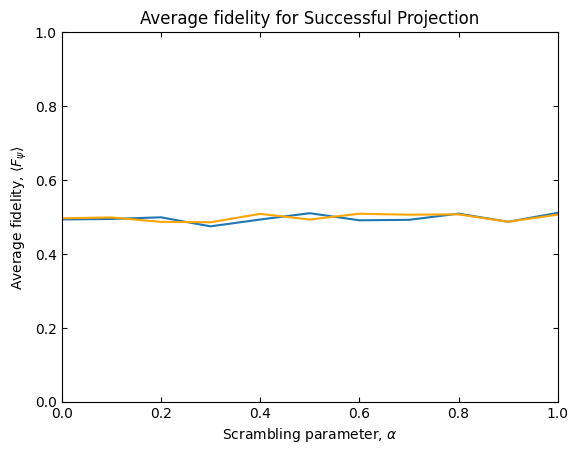

In [15]:
plt.plot(scrambling_parameter, scrambling_fidelity , scalex=False, scaley=False)
plt.plot(scrambling_parameter, identity_fidelity, color = "orange" , scalex=False, scaley=False)
plt.xlabel("Scrambling parameter, $\\alpha$")
plt.ylabel("Average fidelity, $\\langle F_{\\psi} \\rangle$")
plt.tick_params(direction ='in', bottom=True, top=True, left=True, right=True)
plt.title("Average fidelity for Successful Projection")
plt.show()